In [ ]:
!git clone https://github.com/AhMuGeoNa/2022-AI-Competition.git

Cloning into '2022-AI-Competition'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 37 (delta 6), reused 13 (delta 1), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [ ]:
!cp -r 2022-AI-Competition/data data
!mkdir data/csv
!mkdir data/zips
!cp -r "drive/MyDrive/Colab Notebooks/dataset/zips/train.zip" data/train.zip

In [ ]:
!mv data/train.csv data/csv/train.csv
!mv data/test.csv data/csv/test.csv
!mv data/valid.csv data/csv/valid.csv
!mv data/train.zip data/zips/train.zip

!unzip data/zips/train.zip -d data

In [ ]:
## 데이터 처리에 필요한 패키지 로드
from imutils.paths import list_images
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
import cv2, os
import shutil

# **1.데이터셋 전처리**
- 전체 이미지 데이터 셋 10,000장
- 학습 : 시험 : 검증 = 6 : 2 : 2로 분할
- 이미지 중에서 어두운 이미지가 존재하여 이미지 평탄화 진행

In [ ]:
images_path = 'data/images'
csv_path    = 'data/csv'

## csv 파일에 존재하는 정보들을 기반으로하여 라벨별로 데이터 정리하는 함수
def data_organizer(dtype = 'train'):
  df = pd.read_csv(f'{csv_path}/{dtype}.csv')

  for image_path, grade in zip(df['imname'], df['grade']):
    os.makedirs(f'data/{dtype}/{grade}', exist_ok = True)
    shutil.copy(f'{images_path}/{image_path}', f'data/{dtype}/{grade}/{image_path}')

data_organizer()
data_organizer(dtype = 'test')
data_organizer(dtype = 'valid')

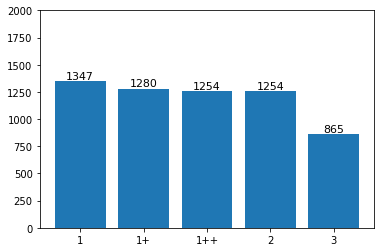

In [ ]:
## 데이터 분포 확인하는 함수
def data_distribution(data_path):
  ## data_path에 있는 이미지 목록을 리스트로 불러오는 부분.
  image_paths = sorted(list_images(data_path))

  ## 이미지 경로에서 '/'을 기준으로 나눈것 중 마지막에서 2번째 값만 가져옴. (라벨값만 가져옴.)
  ## (e.g.) data/train/1++/cow_1++_1002.jpg => 1++
  image_paths = [image_path.split(os.path.sep)[-2] for image_path in image_paths]

  ## 라벨별 개수를 반환해주는 부분 (딕셔너리 형태로 만들어짐)
  label_count = Counter(image_paths)
  label_count = dict(sorted(label_count.items()))

  ## 레이블 별 데이터 분포를 시각화 시키는 코드
  plt.bar(label_count.keys(), label_count.values())
  plt.ylim(0, 2000)

  for grade, num in label_count.items():
      plt.text(
                  grade, num, num,
                  fontsize = 11, color = 'black',
                  horizontalalignment = 'center',
                  verticalalignment = 'bottom'
              )
  plt.show()

## 3등급 이미지가 다른 이미지들에 비해 수가 적은 것을 보임.
## 일단 그냥 한 번 돌려보고 성능이 제대로 나오지 않을 경우에 불균형 해소후 학습
data_distribution('data/train')

In [ ]:
## 라벨을 인덱스 값으로 변경
labels    = set([lb.split(os.path.sep)[-2] for lb in sorted(list_images('data/train'))])
label2idx = {lb : idx for idx, lb in enumerate(labels)}
idx2label = {idx : lb for idx, lb in label2idx.items()}

In [ ]:
## 이미지 전처리 해주는 함수
def preprocessing(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    ycrcb_planes = list(cv2.split(image))


    # 밝기 성분에 대해서만 히스토그램 평활화 수행
    ycrcb_planes[0] = cv2.equalizeHist(ycrcb_planes[0])

    image = cv2.merge(ycrcb_planes)
    image = cv2.cvtColor(image, cv2.COLOR_YCrCb2RGB)

    return image

datasets = {}
## 전처리한 이미지를 넘파이 배열로 만들어주는 함수
def buid_dataset(data_path, dtype = 'train'):
  image_paths = sorted(list_images(data_path))

  images, labels = [], []
  for image_path in image_paths:

    image = cv2.imread(image_path)
    image = preprocessing(image)
    image = cv2.resize(image, (240, 240))
    
    images.append(image)
    labels.append(label2idx[image_path.split(os.path.sep)[-2]])

  datasets[dtype] = [np.array(images), np.array(labels)]
  return datasets

datasets = buid_dataset('data/train')
datasets = buid_dataset('data/test', dtype = 'test')
datasets = buid_dataset('data/valid', dtype = 'valid')

(248, 200, 3)


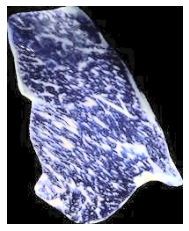

In [ ]:
## 원본 이미지
image = cv2.imread('data/train/1++/cow_1++_1074.jpg')
plt.axis(False)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## 전처리한 이미지
image = preprocessing(image)
print(image.shape)

plt.axis(False)
plt.imshow(image)

# **2. 학습 진행하기**
## **2-1. 데이터 셋 구성하기**

In [ ]:
## 사전 학습된 모델을 불러오는 패키지
!pip install timm

In [ ]:
## 신경망 구성에 필요한 패키지 로드
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import Adam, AdamW
from torchvision import transforms
import torch.nn.functional as F
from torchvision import utils
import torch.nn as nn
import easydict
import torch
import timm

In [ ]:
NUM_CLASSES = 5
SEED        = 99
DEVICE      = 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_WORKERS = 1
PIN_MEMORY  = True

HIDDEN_DIMS  = 128
DROP_OUT_RATE    = 0.1

EPOCHS      = 30
BATCH_SIZE  = 64
LR        = 1e-4
CLIP_GRAD   = 10
LOG_STEPS   = 50
PATIENCE    = 5

In [ ]:
## 커스텀 데이터셋 생성
class BeafData(Dataset):

  def __init__(self, images, labels, dtype = 'train'):

    self.images = images
    self.labels = labels
    self.dtype  = dtype
    
    self.transform = {}
    self.transform['train'] = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                    transforms.ToTensor()             
                              ])
    self.transform['test'] = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.ToTensor()             
                          ])

    self.transform['valid'] = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.ToTensor()             
                      ])

    ## tensor data형태는 (배치, 채널, 너비, 높이) 순으로 정렬되어 있어,
    ## 변경해주어야함.
    self.images    = np.transpose(self.images, (0, 3, 1, 2))
    self.num_datas = self.labels.shape[0]

  ## 이미지, 라벨 데이터를 튜플형태로 변환
  def __getitem__(self, index):
    image = self.images[index].reshape(240, 240, 3)

    image = self.transform[self.dtype](image)
    return image, self.labels[index]

  def __len__(self):
    return self.num_datas

In [ ]:
train_images, train_labels = datasets['train']
train_dataset              = BeafData(train_images, train_labels)
train_loader               = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

torch.Size([3, 240, 240])


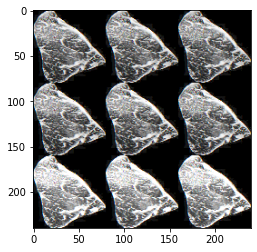

In [98]:
data_iter = iter(train_loader)

images, labels = next(data_iter)
image = images[0]

print(image.shape)
plt.imshow(np.transpose(image, (1, 2, 0)))

## **2-2. 신경망 구성하기**
- timm을 이용한 사전 학습모델 사용하여 신경망 구성
- 이미지 데이터가 248 x 200 이미지 이므로,   
  사전 학습 모델의 입력 사이즈가 240 x 240인 것으로 테스트 해보기

In [ ]:
## efficientnet 목록
timm.list_models('*efficientnet*')

['efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'efficientnetv2_s',
 'efficientnetv2_xl',
 'gc_efficientnetv2_rw_t',
 'tf_efficientnet_b0',
 'tf_efficientnet_b0_ap',
 'tf_efficientnet_b0_ns',
 'tf_efficientnet_b1',
 'tf_efficientnet_b1_ap',
 'tf_efficientnet_b1_ns',
 'tf_efficientnet_b2',
 'tf_efficien

In [ ]:
model = timm.create_model('efficientnet_b1_pruned', 
                          pretrained = True, num_classes = NUM_CLASSES)

for name, param in model.named_parameters():
  ## fully connected 레이어의 가중치와 편향만 학습시키도록 설정
  if name in ['fc.weight', 'fc.bias']: param.requires_grad = True
  else: param.requires_grad = False

Downloading: "https://imvl-automl-sh.oss-cn-shanghai.aliyuncs.com/darts/hyperml/hyperml/job_45403/outputs/effnetb1_pruned_9ebb3fe6.pth" to /root/.cache/torch/hub/checkpoints/effnetb1_pruned_9ebb3fe6.pth
